In [1]:
# Load the Martinez dataset and normalize it
import scipy
import numpy as np
from data.data_loading_utils import load_martinez_XY, DataConventions

X, Y = load_martinez_XY(DataConventions.R)
# The code is written in such a way that we are trying to remove samples that will cause an increase in our fit parameter.
# For the Martinez example, we want to bound decreases to the fit parameter, so we just negate the labels.
Y = -Y
X_orig = np.copy(X)
num_samples, dimension = X.shape
mu = np.average(X, axis=0)
# av_X = X - np.reshape(mu, (1, dimension))
av_X = X
Sigma = av_X.transpose() @ av_X
root_Sigma = scipy.linalg.sqrtm(Sigma)
norm_X = av_X @ np.linalg.inv(root_Sigma)
norm_Y = Y - np.average(Y)
X = norm_X
Y = norm_Y

In [2]:
# Compute the linear fit and error bar on our axis of interest. Compute the Xe and Xr arrays and the Xer vector
from src.utils.linear_algebra import compute_ols_and_error

beta, beta_error_bars, _ = compute_ols_and_error(X, Y)
residuals = Y - (X @ beta)

# X' = A @ X, for A = np.linalg.inv(root_Sigma).
# beta \in dual of X, as we are working with <X, beta> = fixed
# Therefore beta' = A.inv @ beta.
# We care about <e, beta> = <e', beta'> => e' = A @ e as e is in the dual of beta
axis_of_interest = np.concatenate((np.zeros(dimension - 1), [1])) @ np.linalg.inv(root_Sigma)
# axis_of_interest = np.concatenate((np.zeros(dimension - 1), [1]))
beta_e = beta @ axis_of_interest
print(f"<beta, e> = {beta_e}")


XR = residuals[:, np.newaxis] * X
Xe = (X @ axis_of_interest)[:, np.newaxis] * X
Xer = XR @ axis_of_interest

<beta, e> = -0.021637647260104413


In [3]:
from src.lower_bounds.amip import approximate_most_influential_pertrubation
from src.lower_bounds.lower_bounds import process_samples, Flags, BackupSortingLogic
import numpy as np
from typing import List

# Assuming norm_X, axis_of_interest, residuals, and process_samples function are defined in your context

# 1. One-hot with XER as a backup
flags_one_hot_xer = Flags(USE_ONE_HOT=True, BACKUP_SORTING_LOGIC=BackupSortingLogic.XER)
order_one_hot_xer = process_samples(X_orig, norm_X, residuals, flags_one_hot_xer, axis_of_interest)

# 2. XER
xer_scores = norm_X @ axis_of_interest * residuals
order_xer = np.argsort(-xer_scores)

# 3. AMIP
_, amip_gradients = approximate_most_influential_pertrubation(norm_X, residuals, axis_of_interest)
order_amip = np.argsort(-amip_gradients)


In [4]:
from src.lower_bounds.lower_bounds import compute_removal_effects

# Define k_vals and epsilons
num_samples = norm_X.shape[0]
k_vals = np.arange(1, num_samples // 10 + 1)
epsilons = k_vals / num_samples

# Assuming compute_removal_effects function is defined in your context

# Compute removal effects for each sorting
removal_effect_one_hot_xer = compute_removal_effects(norm_X, residuals, axis_of_interest, order_one_hot_xer, k_vals)
removal_effect_xer = compute_removal_effects(norm_X, residuals, axis_of_interest, order_xer, k_vals)
removal_effect_amip = compute_removal_effects(norm_X, residuals, axis_of_interest, order_amip, k_vals)


100%|██████████| 389/389 [00:02<00:00, 136.69it/s]


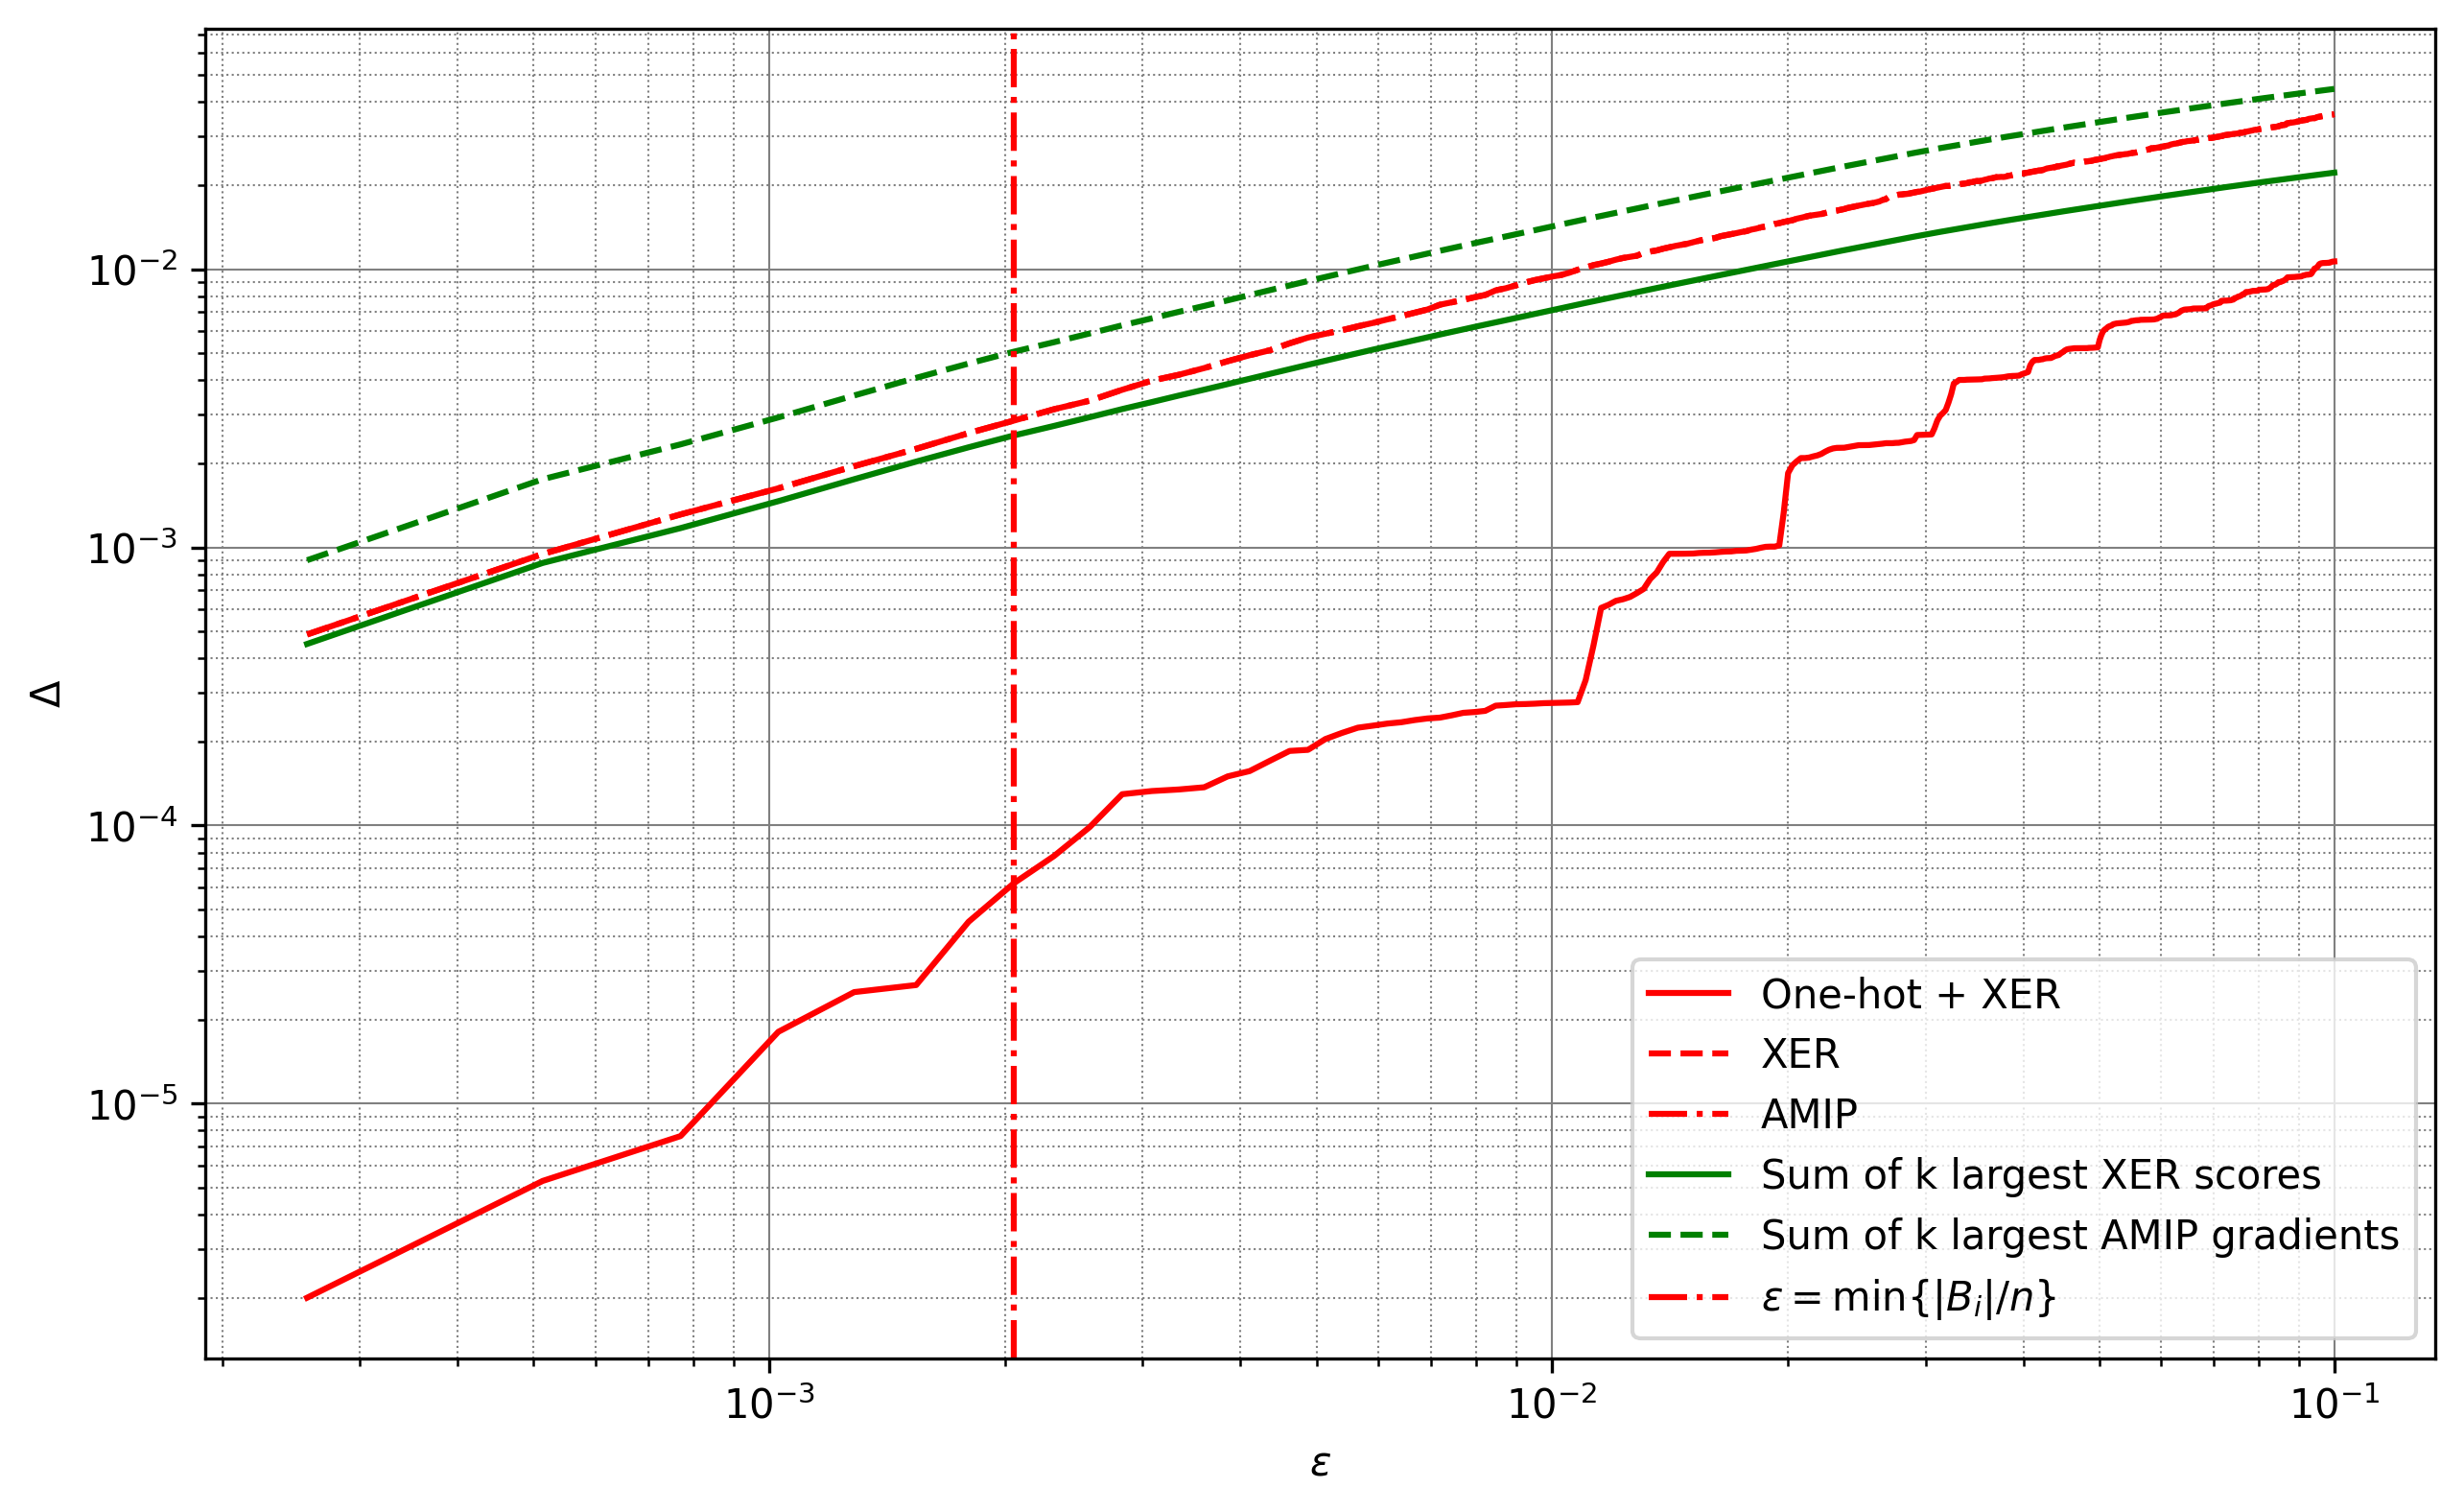

In [18]:


import matplotlib.pyplot as plt
# Plotting removal effects
plt.figure(dpi=300, figsize=(10, 6))
plt.loglog(epsilons, removal_effect_one_hot_xer, 'r-', label='One-hot + XER')
plt.loglog(epsilons, removal_effect_xer, 'r--', label='XER')
plt.loglog(epsilons, removal_effect_amip, 'r-.', label='AMIP')

# Plotting sums of k largest scores/gradients
sorted_xer_scores = np.sort(xer_scores)[::-1]
cumsum_xer_scores = np.cumsum(sorted_xer_scores[:num_samples // 10])
plt.loglog(epsilons, cumsum_xer_scores, 'g-', label='Sum of k largest XER scores')

sorted_amip_gradients = np.sort(amip_gradients)[::-1]
cumsum_amip_gradients = np.cumsum(sorted_amip_gradients[:num_samples // 10])
plt.loglog(epsilons, cumsum_amip_gradients, 'g--', label='Sum of k largest AMIP gradients')

# Enhancing the plot
plt.xlabel('$\epsilon$')
plt.ylabel('$\Delta$')
plt.grid(which='both', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.axvline(x=8 / num_samples, color='r', linestyle='-.', label=r'$\varepsilon = \min \left\{ |B_i|/n \right\}$')
plt.legend()

plt.show()


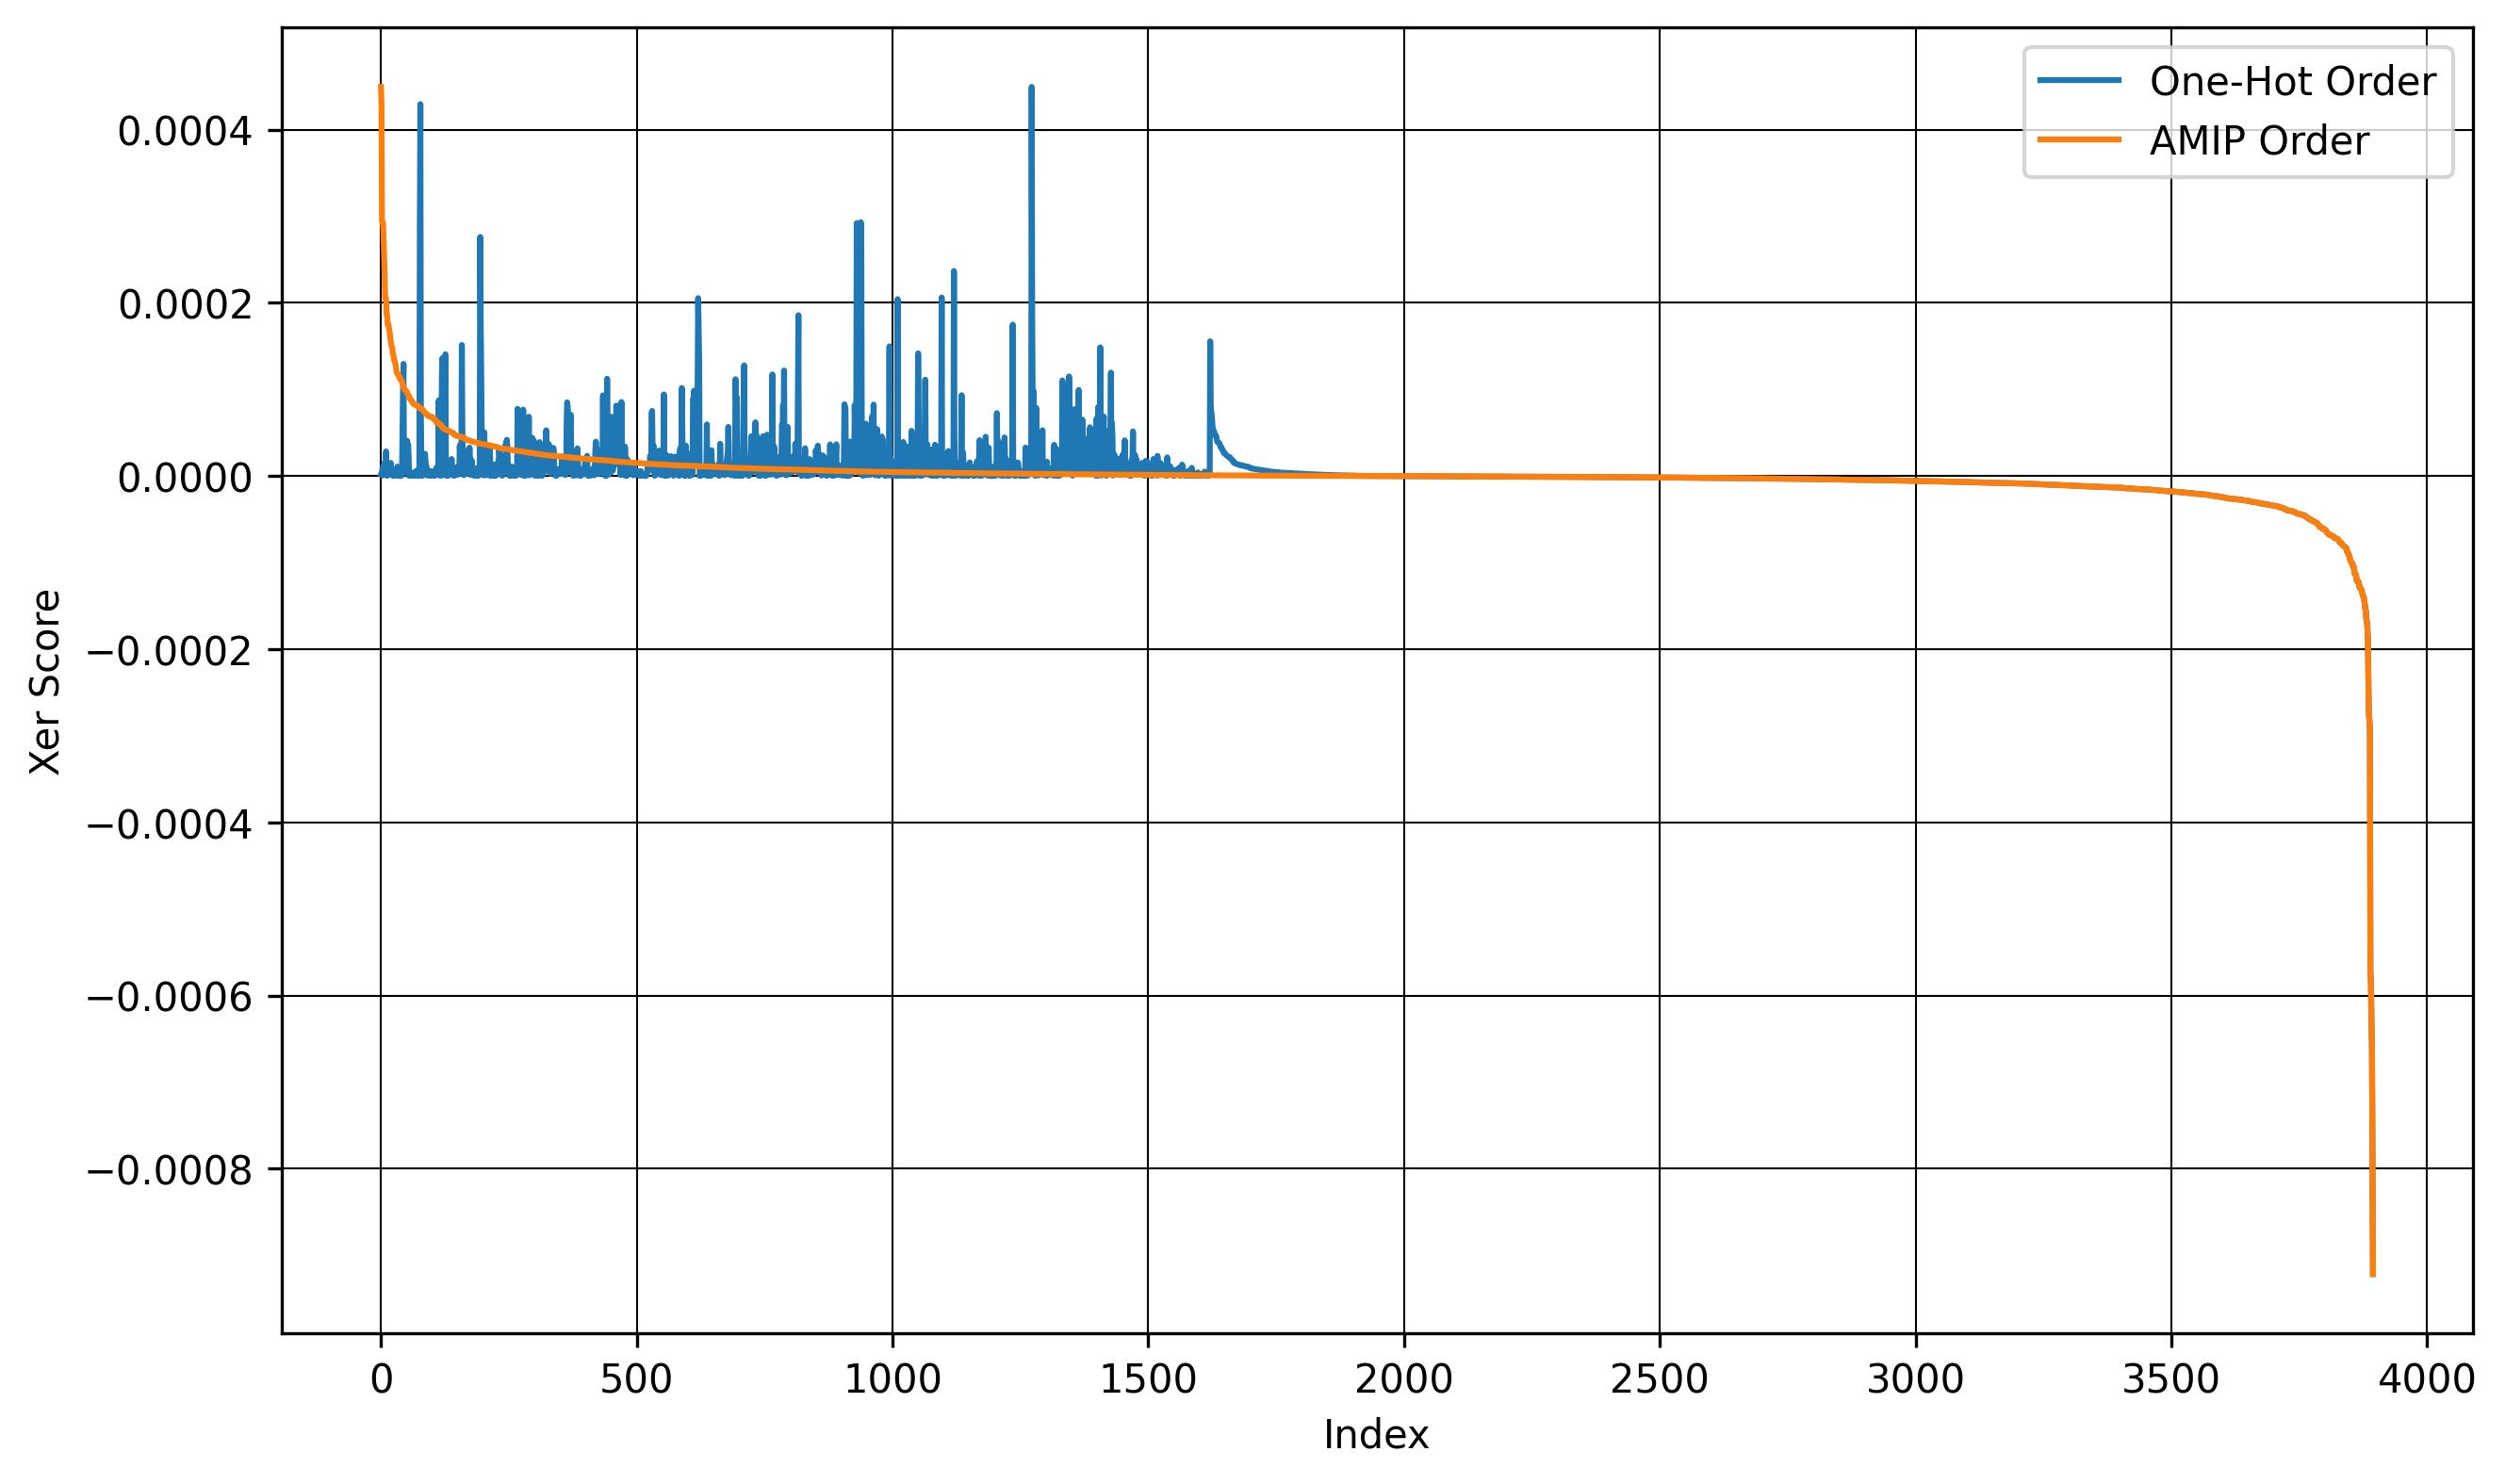

In [17]:
plt.figure(dpi=300, figsize=(10, 6))

plt.plot(Xer[order_one_hot_xer], label='One-Hot Order')
plt.plot(Xer[order_amip], label='AMIP Order')


plt.xlabel('Index')
plt.ylabel('Xer Score')
plt.legend()

plt.grid(which='both', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
